In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import math 
import statsmodels.api as sm

On modifie le précédent modèle en essayant une autre configuration:

$C_i = C_{i-17520} + \frac{1}{336}\sum_{k=0}^{336} C_{k+i-1-336} - C_{k+i-1-17520}$ 

$C_i$ est ici la consommation à l'instant i qu'on souhaite prédire.
NB: $i$ correspond à un pas de temps de 30 minutes, donc 336 représente une semaine, 48 une journée et 17520 une année.

Il s'agit d'un modèle où pour estimer la consommation à un instant i, on prend la consommation une semaine plus tôt au même instant et on la pénalise avec un coéfficient qui est en fait une moyenne mobile. Cette moyenne mobile est la moyenne des écarts observés dans la consommation entre la semaine qui a précédé cet instant et la semaine qui avait précédé la même date un an plus tôt.

In [37]:
def prediction_an(region,timestep):
    data = pd.read_csv('data centrale/train/{}.csv'.format(region),index_col=0)
    train=np.array(data["Consommation"])
    an=365*24*2
    semaine=2*24*7
    for i in range(timestep):
        ecart=train[30672-semaine+i-1:30672+i-1]-train[30672-an-semaine+i-1:30672-an+i-1]
        moyenne_ec=(1/semaine)*sum(ecart)
        prediction=train[30672-semaine+i]+moyenne_ec
        train=np.append(train,prediction)
    pred=train[30673:]
    return pred

In [38]:
#We compare the prediction with the reality
def truevspred(region,timestep):
    pred=prediction_an(region,timestep)
    test = pd.read_csv('data centrale/test/{}.csv'.format(region),index_col=0)
    true=np.array(test["Consommation"])
    b=true[:timestep-1]
    plt.plot(pred,label="prediction")
    plt.plot(b,label="True")
    plt.title("Prediction vs True")
    plt.xlabel("timestep")
    plt.ylabel("Consumption (MW)")
    plt.legend()

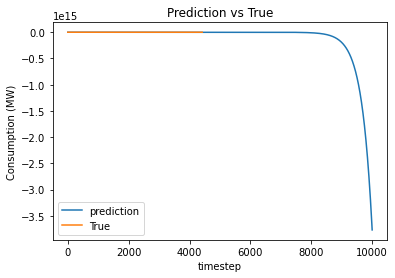

In [39]:
truevspred("ile de france",10000)

In [40]:
#We take a look at the MAPE
def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [41]:
#we take a critical look at our model by looking at its relevance according to the time step
def evol_erreur(region,timestep):
    erreur=[]
    test = pd.read_csv('data centrale/test/{}.csv'.format(region),index_col=0)
    truedata=np.array(test["Consommation"])
    for i in range(1,timestep+2):
        pred=prediction_an(region,i)
        true=truedata[:i-1]
        erreur.append(mean_absolute_percentage_error(true,pred))
        
    plt.plot(erreur,label="MAPE en %")
    plt.title("Evolution of the error as a function of the length of the prediction")
    plt.xlabel("timestep")
    plt.ylabel("Error")
    plt.legend()
        
        
    

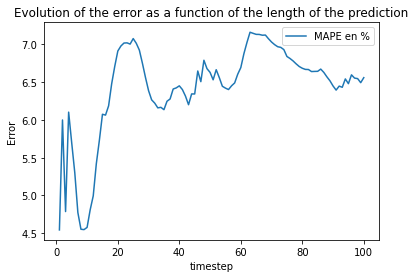

In [43]:
evol_erreur("bretagne",100)

Ce modèle est intéressant à court terme car il permet d'avoir un MAPE en dessous de 7% pour un timestep de 336 (soit environ une semaine), au délà, il explose avec un phénomène d'embalement car ce ne sont plus que les prédictions qui sont utilisées dans le premier coéfficient de la somme. Ainsi, une tendance à la baisse s'emballera car l'écart avec les données de consommation de l'année précédente sera toujours plus important 